# Demo 1: Deblurring as an example of inverse problems in CIL

In this demo we show how to set up an image deblurring inverse problem in CIL and how to solve it with several choices of regularizers.

First we import all tools needed:

In [1]:
# From CIL
from cil.optimisation.algorithms import FISTA
from cil.optimisation.operators import BlurringOperator
from cil.optimisation.functions import LeastSquares, L2NormSquared, L1Norm, TotalVariation, ZeroFunction
from cil.utilities import dataexample, noise
from cil.utilities.display import show2D

# Third-party
import numpy as np

astropy module not found


### A. Setting up the direct problem

CIL comes with a number of test images such as
- `BOAT`
- `CAMERA`
- `PEPPERS`(color)
- `RESOLUTION_CHART` 
- `SIMPLE_PHANTOM_2D` 
- `RAINBOW` (color)

In this demo, we load the `RESOLUTION_CHART` image:

In [2]:
u_true = dataexample.RESOLUTION_CHART.get()
print(u_true)

Number of dimensions: 2
Shape: (256, 256)
Axis labels: ('horizontal_y', 'horizontal_x')



We can display the image (first we define a plotting function to use for consistency throughout):

In [3]:
myshow = lambda image : show2D(image, origin="upper", size=(8,8), fix_range=(0,1))

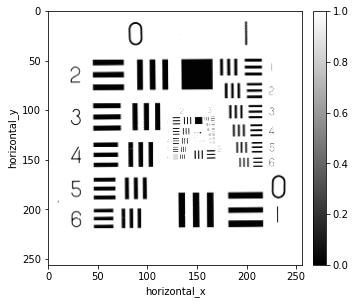

In [4]:
myshow(u_true)

We see that `u_true` is an instance of the CIL `ImageData` class. More image metadata is available in the image's `geometry`:

In [5]:
print(type(u_true))
print('\n')

ig = u_true.geometry
print(ig)

<class 'cil.framework.framework.ImageData'>


Number of channels: 1
channel_spacing: 1.0
voxel_num : x256,y256
voxel_size : x1.0,y1.0
center : x0,y0



We consider the deblurring problem

$$ d = A u + \eta$$

where 
- $u$ is the unknown sharp image
- $A$ is a linear operator representing blurring
- $\eta$ is additive Gaussian noise
- $d$ is the blurred and noisy image.

To set up the direct problem we specify a **point spread function (PSF)** to blur the image through a convolution:

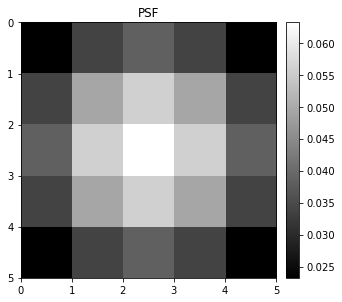

In [6]:
# Parameters for point spread function PSF (size and std)
ks          = 5; 
ksigma      = 2;

# Create 1D PSF and 2D as outer product, then normalise.
w           = np.exp(-np.arange(-(ks-1)/2,(ks-1)/2+1)**2/(2*ksigma**2))
w.shape     = (ks,1)
PSF         = w*np.transpose(w)
PSF         = PSF/(PSF**2).sum()
PSF         = PSF/PSF.sum()

# Display PSF as image
show2D(PSF, origin="upper", title="PSF", size=(8,8))

To be able to apply the blurring to our test image we specify a **BlurringOperator**:

In [7]:
A = BlurringOperator(PSF, ig)

We apply the blurring operator to the test image and display the blurred image:

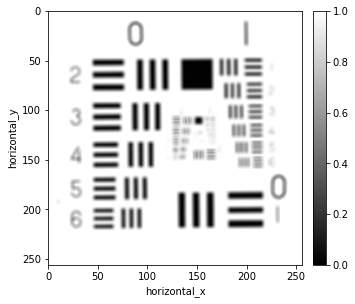

In [8]:
u_blur = A.direct(u_true)
myshow(u_blur)

We finally add some Gaussian noise to the blurred image:

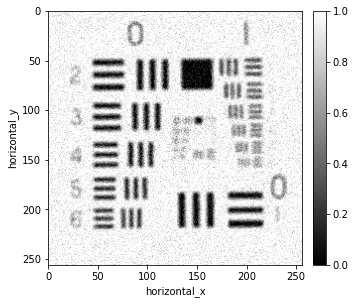

In [9]:
u_blur_noise = noise.gaussian(u_blur, seed=10, var=0.01)
myshow(u_blur_noise)

### B. Specifying and solving the inverse problem as optimization problem

We formulate the image deblurring problem as an optimization problem to simultaneously fit to the data and enforce regularization on the solution. We use a simple least squares data-fitting term with the blurring operator and try out a few different regularizers $\Psi(u)$ in the general form optimization problem:

$$
\min_u  \| A u - d\|^{2}_{2} + \alpha\,\Psi(u)
$$

The choice of $\Psi(u)$ determines the regularization to apply. We first try without regularization, $\Psi(u) = 0$, leaving us with the simpler least-squares optimization problem
$$
\min_u  \| A u - d\|^{2}_{2}
$$

We set up a `LeastSquares` function object:

In [10]:
F = LeastSquares(A, u_blur_noise)
print(F)

`F` is the objective or cost function that we want to minimize. As an example we evaluate it at the zero image:

In [11]:
zero_image = ig.allocate(0.0)
F(zero_image)

51730.953125

And for the image of all one values - this apparently has a smaller `F` value so is closer to minimizer:

In [12]:
F(zero_image + 1)

4893.728515625

We set up an instance of the `FISTA` algorithm with just the `F`, specify starting point, max iterations and how often to print intermediate results:

In [13]:
alg_LS = FISTA(initial=zero_image, 
               f=F, g = ZeroFunction(),
               max_iteration=2000, 
               update_objective_interval=50)

Once set up, we can then run it for some iterations and inspect the preliminary resulting image:

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       2000         0.000          5.17310e+04
-------------------------------------------------------
       10       2000         0.018                     
Stop criterion has been reached.



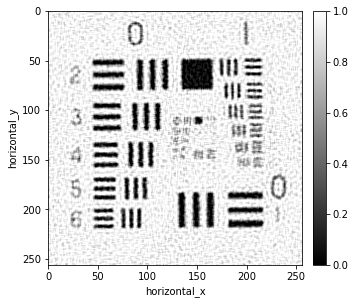

In [14]:
alg_LS.run(10)
myshow(alg_LS.solution)

Still looking blurry and also more noisy. We try running more iterations (note how the algorithm can be resumed):

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       10       2000         0.018                     
       50       2000         0.017          1.65104e+02
      100       2000         0.017          1.27353e+02
-------------------------------------------------------
      100       2000         0.017          1.27353e+02
Stop criterion has been reached.



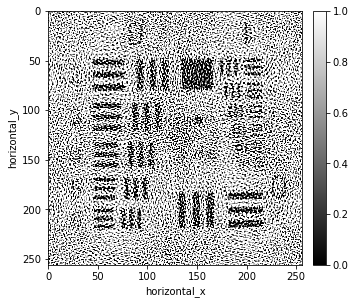

In [15]:
alg_LS.run(90)
myshow(alg_LS.solution)

The image may be getting a bit sharper but also a lot noisier. If we run even more iterations, this just continues:

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
      100       2000         0.017          1.27353e+02
      150       2000         0.018          1.03735e+02
      200       2000         0.018          8.64832e+01
      250       2000         0.018          7.40843e+01
      300       2000         0.018          6.51458e+01
      350       2000         0.018          5.84215e+01
      400       2000         0.018          5.31004e+01
      450       2000         0.018          4.87485e+01
      500       2000         0.018          4.51082e+01
-------------------------------------------------------
      500       2000         0.018          4.51082e+01
Stop criterion has been reached.



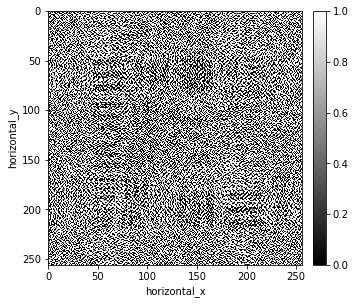

In [16]:
alg_LS.run(400)
myshow(alg_LS.solution)

We need to use some regularization to handle the noise that is exploding by the inversion. We start by trying classic Tikhonov regularization
$$ \Psi(u) = \alpha \cdot \|u\|^2 = \alpha \cdot \sum_j u_j^2$$
which we specify as a CIL `L2NormSquared` function:

In [17]:
G_L2 = 0.2*L2NormSquared()

Another `FISTA` algorithm instance is set up, now with the regularizer passed:

In [18]:
alg_L2 = FISTA(initial=zero_image, 
               f=F, 
               g=G_L2,
               max_iteration=2000, 
               update_objective_interval=50)

We run some iterations and display the result:

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       2000         0.000          5.17310e+04
       50       2000         0.018          9.00935e+03
      100       2000         0.018          9.00935e+03
-------------------------------------------------------
      100       2000         0.018          9.00935e+03
Stop criterion has been reached.



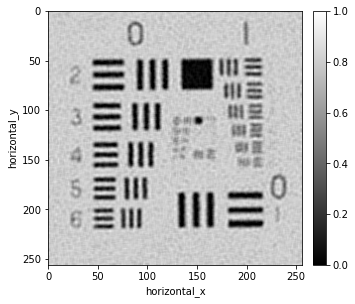

In [19]:
alg_L2.run(100)
myshow(alg_L2.solution)

This is handling the noise better but it is still very smooth, which is the expected behaviour of Tikhonov regularization which introduces smoothing.

We try instead L1-norm regularization, which attempts to enforce sparsity of the image
$$\Psi(u)= \| u\|_1  = \sum_j |u_j| $$
which in CIL looks like

In [20]:
G_L1 = 0.2*L1Norm()

The `FISTA` instance is set up in the same way as before, with the new `g`:

In [21]:
alg_L1 = FISTA(initial=zero_image, 
               f=F, 
               g=G_L1,
               max_iteration=2000, 
               update_objective_interval=50)

We run some iterations and display the result:

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       2000         0.000          5.17310e+04
       50       2000         0.018          1.07735e+04
      100       2000         0.018          1.07534e+04
      150       2000         0.018          1.07476e+04
      200       2000         0.018          1.07457e+04
-------------------------------------------------------
      200       2000         0.018          1.07457e+04
Stop criterion has been reached.



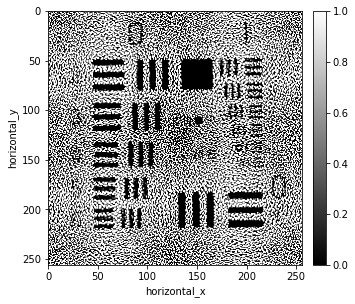

In [22]:
alg_L1.run(200)
myshow(alg_L1.solution)

This produces a sharper image, with some of the noise reduced, but still very noisy.

We finally try Total Variation regularization
$$ \Psi(u) = TV(u) = \|\nabla u\|_{2,1} $$
which attempts to make the gradient image sparse, which correcsponds to a piecewise constant image.

In [23]:
G_TV = 0.02 * TotalVariation()

In [24]:
alg_TV = FISTA(initial=zero_image, 
               f=F, 
               g=G_TV,
               max_iteration=2000, 
               update_objective_interval=50)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       2000         0.000          5.17310e+04
       50       2000         0.281          3.68361e+02
      100       2000         0.275          3.68356e+02
      150       2000         0.271          3.68356e+02
      200       2000         0.270          3.68356e+02
-------------------------------------------------------
      200       2000         0.270          3.68356e+02
Stop criterion has been reached.



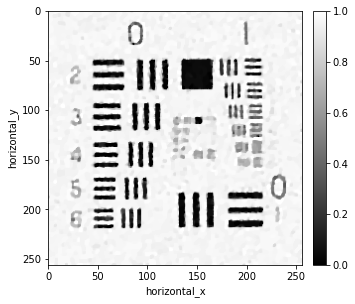

In [25]:
alg_TV.run(200)
myshow(alg_TV.solution)

We see the noise is reduced a lot and the larger bars are well recovered. However the smaller bars are blending together.  One can play with the choice regularization parameter to study the trade-off.

In general, TV tends to reproduce larger features like this very well from noisy data, but lose small features.

Finally we compare all the reconstructions:

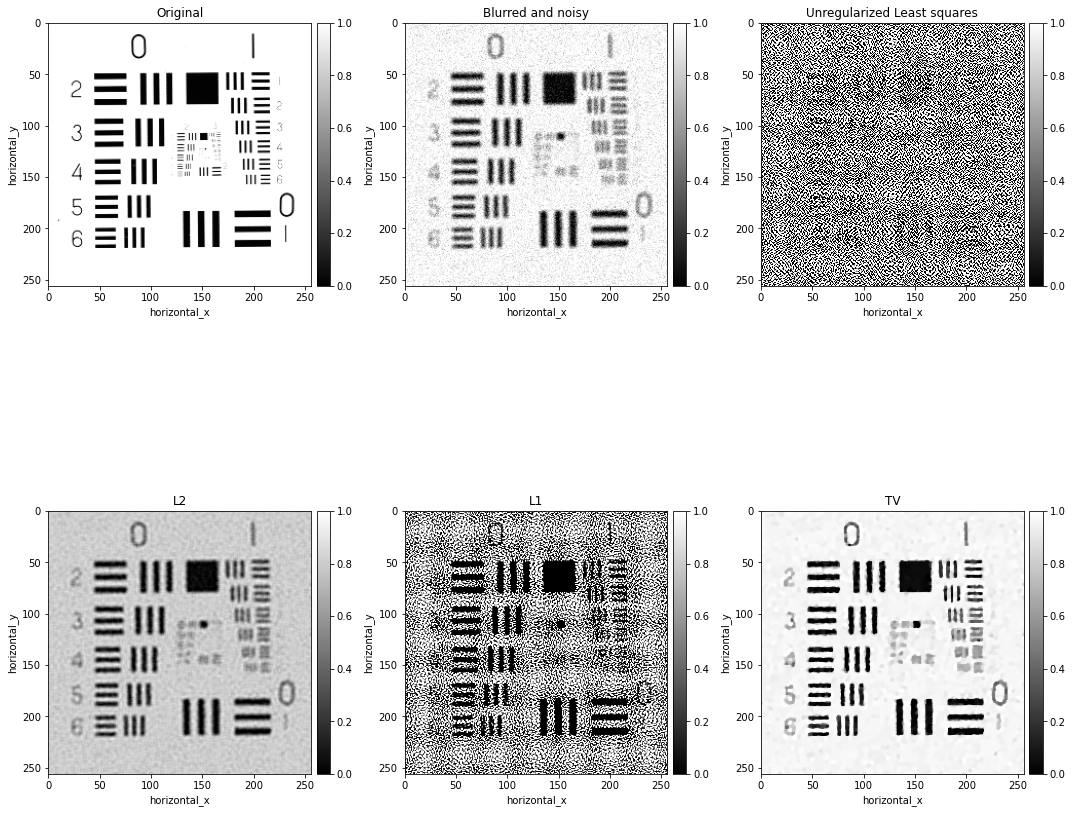

In [26]:
show2D([u_true, u_blur_noise, alg_LS.solution,  alg_L2.solution, alg_L1.solution, alg_TV.solution], 
       title=['Original', 'Blurred and noisy', 'Unregularized Least squares', 'L2',  'L1', 'TV'], 
       origin="upper", 
       fix_range=(0,1), 
       num_cols=3)